# Statistics
This notebook provides an overview of the functions provided by the elephant `statistics` module.


## 1. Generating homogeneous Poisson and Gama processes

All measures presented here require one or two spiketrains as input. We start by importing physical quantities (seconds, milliseconds and Hertz) and two generators of spiketrains - `homogeneous_poisson_process()` and `homogeneous_gamma_process()` functions from `elephant.spike_train_generation` module.

Let's explore `homogeneous_poisson_process()` function in details with Python `help()` command.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from quantities import ms, s, Hz
from elephant.spike_train_generation import homogeneous_poisson_process, homogeneous_gamma_process

In [2]:
help(homogeneous_poisson_process)

Help on function homogeneous_poisson_process in module elephant.spike_train_generation:

homogeneous_poisson_process(rate, t_start=array(0.) * ms, t_stop=array(1000.) * ms, as_array=False, refractory_period=None)
    Returns a spike train whose spikes are a realization of a Poisson process
    with the given rate, starting at time `t_start` and stopping time `t_stop`.
    
    All numerical values should be given as Quantities, e.g. `100*pq.Hz`.
    
    Parameters
    ----------
    rate : pq.Quantity
        The rate of the discharge.
    t_start : pq.Quantity, optional
        The beginning of the spike train.
        Default: 0 pq.ms
    t_stop : pq.Quantity, optional
        The end of the spike train.
        Default: 1000 pq.ms
    as_array : bool, optional
        If True, a NumPy array of sorted spikes is returned,
        rather than a `neo.SpikeTrain` object.
        Default: False
    refractory_period : pq.Quantity, optional
        `pq.Quantity` scalar with dimension time

The function requires four parameters: the firing rate of the Poisson process, the start time and the stop time, and the refractory period (default `refractory_period=None` means no refractoriness). The first three parameters are specified as Quantity objects: these are essentially arrays or numbers with a unit of measurement attached. To specify `t_start` to be equal to 275.5 milliseconds, you write

In [3]:
t_start = 275.5 * ms
print(t_start)

275.5 ms


The nice thing about Quantities is that once the unit is specified you don't need to worry about rescaling the values to a common unit 'cause Quantities takes care of this for you:

In [4]:
t_start2 = 3. * s
t_start_sum = t_start + t_start2
print(t_start_sum)

3275.5 ms


For a complete set of operations with quantities refer to its [documentation](https://python-quantities.readthedocs.io/en/latest/).

Let's get back to spiketrains generation. In this example we'll use one Poisson and one Gamma processes.

In [5]:
np.random.seed(28)  # to make the results reproducible
spiketrain1 = homogeneous_poisson_process(rate=10*Hz, t_start=0.*ms, t_stop=10000.*ms)
spiketrain2 = homogeneous_gamma_process(a=3, b=10*Hz, t_start=0.*ms, t_stop=10000.*ms)

Both spiketrains are instances of `neo.core.spiketrain.SpikeTrain` class:

In [6]:
print("spiketrain1 type is", type(spiketrain1))
print("spiketrain2 type is", type(spiketrain2))

spiketrain1 type is <class 'neo.core.spiketrain.SpikeTrain'>
spiketrain2 type is <class 'neo.core.spiketrain.SpikeTrain'>


The important properties of a `SpikeTrain` are:

* `times` stores the spike times in a numpy array with the specified units;
* `t_start` - the beginning of the recording/generation;
* `t_stop` - the end of the recording/generation.

In [7]:
print(f"spiketrain2 has {len(spiketrain2)} spikes:")
print("  t_start:", spiketrain2.t_start)
print("  t_stop:", spiketrain2.t_stop)
print("  spike times:", spiketrain2.times)

spiketrain2 has 31 spikes:
  t_start: 0.0 ms
  t_stop: 10000.0 ms
  spike times: [ 379.69226731  721.17083962  981.4600578  1818.07697508 1930.07766122
 2117.27420237 2247.71381158 2474.5892971  2909.11315779 3322.25690782
 3655.2369896  4204.16482203 4636.17324707 4857.75363151 5128.2982248
 5503.67720515 5711.07539264 5901.13841203 6343.81107862 6644.59205905
 6961.02653437 7099.66475138 7771.05116137 7990.03297516 8243.50574847
 8307.54382197 8532.54018371 9343.19166643 9492.66298758 9675.44381775
 9828.78058714] ms


Before exploring the statistics of spiketrains, let's look at the rasterplot. In the next section we'll compare numerically the difference between two.

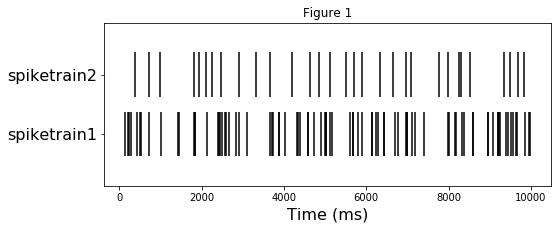

In [8]:
plt.figure(figsize=(8, 3))
plt.eventplot([spiketrain1, spiketrain2], linelengths=0.75, color='black')
plt.xlabel('Time (ms)', fontsize=16)
plt.yticks([0,1], labels=["spiketrain1", "spiketrain2"], fontsize=16)
plt.title("Figure 1");

## 2. Rate estimation

Elephant offers three approaches for estimating the underlying rate of a spike train.

### 2.1. Mean firing rate

The simplest approach is to assume a stationary firing rate and only use the total number of spikes and the duration of the spike train to calculate the average number of spikes per time unit. This results in a single value for a given spiketrain.

In [9]:
from elephant.statistics import mean_firing_rate

In [10]:
print("The mean firing rate of spiketrain1 is", mean_firing_rate(spiketrain1))
print("The mean firing rate of spiketrain2 is", mean_firing_rate(spiketrain2))

The mean firing rate of spiketrain1 is 0.0086 1/ms
The mean firing rate of spiketrain2 is 0.0031 1/ms


The mean firing rate of `spiketrain1` is higher than of `spiketrain2` as expected from the Figure 1.

Let's quickly check the correctness of the `mean_firing_rate()` function by computing the firing rates manually:

In [11]:
fr1 = len(spiketrain1) / (spiketrain1.t_stop - spiketrain1.t_start)
fr2 = len(spiketrain2) / (spiketrain2.t_stop - spiketrain2.t_start)
print("The mean firing rate of spiketrain1 is", fr1)
print("The mean firing rate of spiketrain2 is", fr2)

The mean firing rate of spiketrain1 is 0.0086 1/ms
The mean firing rate of spiketrain2 is 0.0031 1/ms


Additionally, the period within the spike train during which to estimate the firing rate can be further limited using the `t_start` and `t_stop` keyword arguments. Here, we limit the firing rate estimation to the first second of the spiketrain.

In [12]:
mean_firing_rate(spiketrain1, t_start=0*ms, t_stop=1000*ms)

array(0.008) * 1/ms

In some (rare) cases multiple spiketrains can be represented in multidimensional arrays when they contain the same number of spikes. In such cases, the mean firing rate can be calculated for multiple spiketrains at once by specifying the axis the along which to calculate the firing rate. By default, if no axis is specified, all spiketrains are pooled together before estimating the firing rate.

In [13]:
multi_spiketrains = np.array([[1,2,3],[4,5,6],[7,8,9]])*ms
mean_firing_rate(multi_spiketrains, axis=0, t_start=0*ms, t_stop=5*ms)

array([0.4, 0.4, 0.2]) * 1/ms

### 2.2. Time histogram
The time histogram is a time resolved way of the firing rate estimation. Here, the spiketrains are binned and either the count or the mean count or the rate of the spiketrains is returned, depending on the `output` parameter. The result is a count (mean count/rate value) for each of the bins evaluated. This is represented as a neo `AnalogSignal` object with the corresponding sampling rate and the count (mean count/rate) values as data.

Here, we compute the counts of spikes in bins of 500 millisecond width.

In [14]:
from elephant.statistics import time_histogram, instantaneous_rate

In [15]:
histogram_count = time_histogram([spiketrain1], 500*ms)

In [16]:
print(type(histogram_count), f"of shape {histogram_count.shape}: {histogram_count.shape[0]} samples, {histogram_count.shape[1]} channel")
print('sampling rate:', histogram_count.sampling_rate)
print('times:', histogram_count.times)
print('counts:', histogram_count.T[0])

<class 'neo.core.analogsignal.AnalogSignal'> of shape (20, 1): 20 samples, 1 channel
sampling rate: 0.002 1/ms
times: [   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500. 5000. 5500.
 6000. 6500. 7000. 7500. 8000. 8500. 9000. 9500.] ms
counts: [5. 3. 3. 3. 5. 5. 1. 5. 4. 4. 5. 5. 6. 5. 3. 1. 5. 4. 7. 7.] dimensionless


`AnalogSignal` is a container for analog signals of any type, sampled at a fixed sampling rate.

In our case,

1. The shape of `histogram_count` is (20, 1) - 20 samples in total, 1 channel. A "channel" comes from the fact that `AnalogSignal`s are naturally used to represent recordings from Utah arrays with many electrodes (channels) in electrophysiological experiments. In such experiments `AnalogSignal` stores the voltage through time for each electrode (channel), leading to a two-dimensional array of shape `(#samples, #channels)`. In our example, however, `AnalogSignal` stores `dimensionless` type of data because the counts - the number of spikes per bin - have no physical unit, of course. And a "channel" is introduced to be consistent with the definition of `AnalogSignal` which should always be a two-dimensional array.
2. The sampling rate of `histogram_count` is `0.002 1/ms` or 2 Hz. Thus each second interval contains 2 samples.
3. `.times` property is a numpy array with seconds or milliseconds unit.
4. The data itself, the counts, is dimensionless.

Alternatively, `time_histogram` can also normalize the resulting array to represent the counts mean or the rate.

In [17]:
histogram_rate = time_histogram([spiketrain1], 500*ms, output='rate')

In [18]:
print('times:', histogram_rate.times)
print('rate:', histogram_rate.T[0])

times: [   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500. 5000. 5500.
 6000. 6500. 7000. 7500. 8000. 8500. 9000. 9500.] ms
rate: [0.01  0.006 0.006 0.006 0.01  0.01  0.002 0.01  0.008 0.008 0.01  0.01
 0.012 0.01  0.006 0.002 0.01  0.008 0.014 0.014] 1/ms


Additionally, `time_histogram` can be limited to a shorter time period by using the keyword arguments `t_start` and `t_stop`, as described for `mean_firing_rate`.

### 2.3. Instantaneous rate

The instantaneous rate is, similar to the time histogram (see above), provides a continuous estimate of the underlying firing rate of a spike train. Here, the firing rate is estimated as a convolution of the spiketrain with a firing rate kernel, representing the contribution of a single spike to the firing rate. In contrast to the time histogram, the instantaneous rate provides a smooth firing rate estimate as it does not rely on binning of a spiketrain.

Estimation of the instantaneous rate requires a sampling period on which the firing rate is estimated. Here we use a sampling period of 50 millisecond.

In [19]:
inst_rate = instantaneous_rate(spiketrain1, sampling_period=50*ms)

The resulting rate estimate is again an `AnalogSignal` with the sampling rate of `1 / (50 ms)`.

In [20]:
print(type(inst_rate), f"of shape {inst_rate.shape}: {inst_rate.shape[0]} samples, {inst_rate.shape[1]} channel")
print('sampling rate:', inst_rate.sampling_rate)
print('times (first 10 samples): ', inst_rate.times[:10])
print('instantaneous rate (first 10 samples):', inst_rate.T[0, :10])

<class 'neo.core.analogsignal.AnalogSignal'> of shape (200, 1): 200 samples, 1 channel
sampling rate: 0.02 1/ms
times (first 10 samples):  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] (0.05*s)
instantaneous rate (first 10 samples): [3.83424813 3.90825063 3.98230283 4.05636899 4.13041362 4.20440153
 4.27829792 4.35206838 4.42567899 4.49909633] Hz


Additionally, the convolution kernel type can be specified via the `kernel` keyword argument. E.g. to use an gaussian kernel, we do as follows:

In [21]:
from elephant.kernels import GaussianKernel
instantaneous_rate(spiketrain1, sampling_period=20*ms, kernel=GaussianKernel(200*ms))

AnalogSignal with 1 channels of length 500; units Hz; datatype float64 
annotations: {'t_stop': array(500.) * (0.02*s)}
sampling rate: 0.05 1/ms
time: 0.0 (0.02*s) to 500.0 (0.02*s)

To compare all three methods of firing rate estimation, we visualize the results of all methods in a common plot.

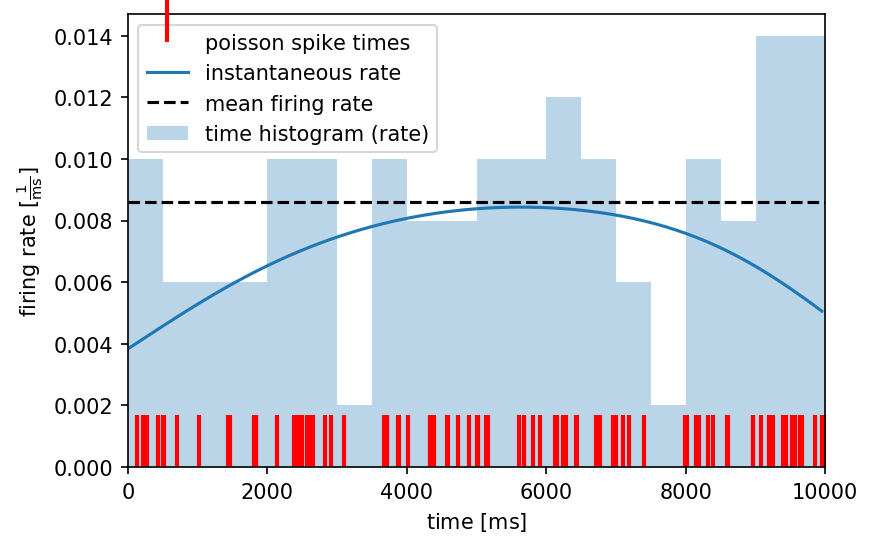

In [22]:
plt.figure(dpi=150)

# plotting the original spiketrain
plt.plot(spiketrain1, [0]*len(spiketrain1), 'r', marker=2, ms=25, markeredgewidth=2, lw=0, label='poisson spike times')

# mean firing rate
plt.hlines(mean_firing_rate(spiketrain1), xmin=spiketrain1.t_start, xmax=spiketrain1.t_stop, linestyle='--', label='mean firing rate')

# time histogram
plt.bar(histogram_rate.times, histogram_rate.magnitude.flatten(), width=histogram_rate.sampling_period, align='edge', alpha=0.3, label='time histogram (rate)')

# instantaneous rate
plt.plot(inst_rate.times.rescale(ms), inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(), label='instantaneous rate')

# axis labels and legend
plt.xlabel('time [{}]'.format(spiketrain1.times.dimensionality.latex))
plt.ylabel('firing rate [{}]'.format(histogram_rate.dimensionality.latex))
plt.xlim(spiketrain1.t_start, spiketrain1.t_stop)
plt.legend()
plt.show()

## Coefficient of Variation (CV)

In this section we will numerically verify that the coefficient of variation (CV), a measure of the variability of inter-spike intervals, of a spike train that is modeled as a random (stochastic) Poisson process, is 1.

Let us generate 100 independent Poisson spike trains for 100 seconds each with a rate of 10 Hz for which we later will calculate the CV. For simplicity, we will store the spike trains in a list.

In [23]:
spiketrain_list = [
     homogeneous_poisson_process(rate=10.0*Hz, t_start=0.0*s, t_stop=100.0*s)
     for i in range(100)]

Let's look at the rasterplot of the first second of spiketrains.

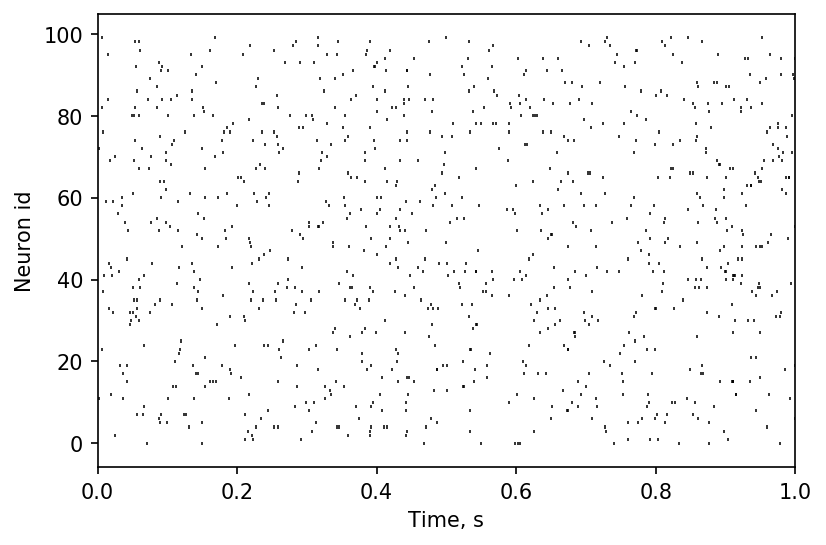

In [24]:
plt.figure(dpi=150)
plt.eventplot(spiketrain_list, linelengths=0.75, linewidths=0.75, color='black')
plt.xlabel("Time, s")
plt.ylabel("Neuron id")
plt.xlim([0, 1]);

From the plot you can see the random nature of each Poisson spike train. Let us verify it numerically by calculating the distribution of the 100 CVs obtained from inter-spike intervals (ISIs) of these spike trains.

For each spike train in our list, we first call the `isi()` function which returns an array of all N-1 ISIs for the N spikes in the input spike train. We then feed the list of ISIs into the `cv()` function, which returns a single value for the coefficient of variation:

In [25]:
from elephant.statistics import isi, cv
cv_list = [cv(isi(spiketrain)) for spiketrain in spiketrain_list]

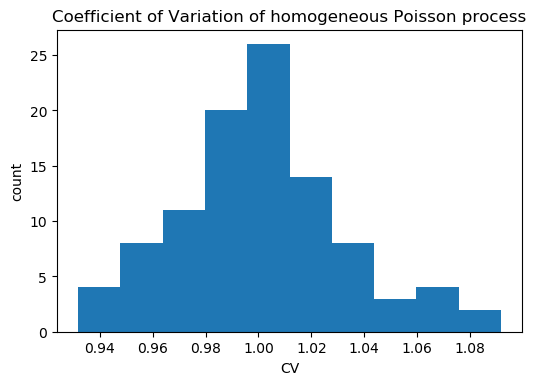

In [26]:
# let's plot the histogram of CVs
plt.figure(dpi=100)
plt.hist(cv_list)
plt.xlabel('CV')
plt.ylabel('count')
plt.title("Coefficient of Variation of homogeneous Poisson process");

As predicted by theory, the CV values are clustered around 1.

# TODO

## Spike interval statistics

## Statistics across spike trains